# **Übung 5: Der Tragflügel im stationären Kurvenflug**

Im stationären Kurvenflug entsteht eine unsymmetrische Anströmung, die ein Rollmoment am Flügel verursacht. Dieses Rollmoment muss durch einen Querruderausschlag kompensiert werden. Berechnen Sie den notwendigen Ruderausschlag für einen Rechteck- flügel von 15m Spannweite bei einem Hängewinkel von φ = 30◦. Die Klappentiefe soll lQ = 0,2l betragen. Die Position des Klappenbeginns soll bei 65% der Halbspannweite liegen.

In [1]:
# Importieren von Python-Biblioteken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Erhöhen der Plot-Auflösung
plt.rcParams["figure.dpi"] = 140

### **5.1.1 Geometrische Parameter und Randbedinungen**

In [2]:
# Konstant
U_inf = 20.0                    # Bahngeschwindigkeit der Flügelwurzel [m/s]
rho = 1.225                     # Dichte [kg/m^3]
l_i = 1.0                       # Flügeltiefe Rumpfmitte [m]
l_a = 1.0                       # Flügeltiefe außen [m]
l_r = 0.2                       # Rudertiefe [m]
b = 15.0                        # Spannweite [m]
phi = 30 * np.pi / 180          # Hängewinkel
N = 500                         # Anzahl Elementarflügel
delta_b = b/ N                  # Elementarflügelbreite

#### 🟠

In [3]:
# Diese Parameter können verändert werden
alpha = 10.0                    # Anstellwinel [deg]
xi = 30.0                       # Klappenwinkel [deg]
r = 80.0                        # Kurvenradius [m]

#### Berechnung weiterer geometrischer Parameter

In [4]:
alpha = alpha / 180 * np.pi     # Anstellwinel [rad] 
xi = xi / 180 * np.pi           # Anstellwinel [rad] 

# Berechnung der Halbspannweite, Flügelfläche und Sreckung
s = b / 2 
S = b/2 * (l_a + l_i)  
AR = b**2 / S     

# Verhältnis Rudertiefe-Flügeltiefe und spannweitige Position
lamda = l_r / l_i
y_ruder = 0.65 * s

# Berechnung des Nullanstellwinkels des Klappenprofils
alpha_0 = - 2 / np.pi * (np.asin(np.sqrt(lamda)) + np.sqrt(lamda * (1 - lamda))) * xi

# Berechnung der Drehgeschwindigkeit
psi = U_inf / r


print("Spannweitige Position der Ruder:         ", "%.3f" % y_ruder, "m")
print("Drehgeschwindigkeit:                     ", "%.3f" % (psi * 180 / np.pi), "°/s")
print("Nullanstellwinkel des Klappenprofils:    ", str(round(alpha_0 * 180 / np.pi, 2)) + "°")

Spannweitige Position der Ruder:          4.875 m
Drehgeschwindigkeit:                      14.324 °/s
Nullanstellwinkel des Klappenprofils:     -16.49°


### **5.1.2 Berechnung der Hufeisenwirbel-Koordinaten**

In [5]:
def x_position(y, l_i, l_a, s, aufpunkt=False):
    """Berechnet die Tiefenposition der Punkte A und B und des Aufpunkts C"""

    tiefe = 0.75 if aufpunkt else 0.25
    return abs(y) / s * (l_i - l_a) / 2 + tiefe * (l_i - abs(y) / s * (l_i - l_a))


def compute_coords(s, N, delta_b, l_i, l_a):
    """Berechnet die Hufeisenwirbel-Koordinaten aus Basis der Flügelgeometrie und Anzahl der Elementarflügel"""

    # Spannweitige Positionen der Punkte A, B und Aufpunkt C
    y_a = np.array([-s +  j    * delta_b for j in range(N)])
    y_b = np.array([-s + (j+1) * delta_b for j in range(N)])
    y_c = np.array([-s + delta_b/2 + i*delta_b for i in range(N)])
    
    # Tiefenposition der Punkte A und B und des Aufpunkts C
    x_a = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_a])
    x_b = np.array([x_position(y_i, l_i, l_a, s) for y_i in y_b])
    x_c = np.array([x_position(y_i, l_i, l_a, s, True) for y_i in y_c])

    # Spannweitige Positionen der bis ins Unendliche reichenden nichttragenden Wirbel
    y_aoo = np.array([-s +  j    * delta_b for j in range(N)])
    y_boo = np.array([-s + (j+1) * delta_b for j in range(N)])

    # Tiefenposition der bis ins Unendliche reichenden nichttragenden Wirbel
    x_aoo = x_a + 100*s
    x_boo = x_b + 100*s

    return y_a, y_b, y_c, x_a, x_b, x_c, y_aoo, y_boo, x_aoo, x_boo

# Berechnen aller Hufeisenwirbel-Koordinaten
y_a, y_b, y_c, x_a, x_b, x_c, y_aoo, y_boo, x_aoo, x_boo = compute_coords(s, N, delta_b, l_i, l_a)

### **5.1.3 Berechnung der Koeffizientenmatrix**

In [6]:
def compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c):
    """Berechnet die drei Anteile der Koeffizientenmatrix"""
    
    # Initialisieren der Matrizen
    a_AB = np.zeros((x_a.size, x_a.size), dtype=float)
    a_Aoo = np.zeros((x_a.size, x_a.size), dtype=float)
    a_Boo = np.zeros((x_a.size, x_a.size), dtype=float)

    # Berechnen der Anteile der gebundenen Wirbel
    for j in range(N):
        for i in range(N):
            a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

    # Berechnen der Anteile der freien Wirbel der linken Seite
    for j in range(N):
        for i in range(N):
            a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

    # Berechnen der Anteile der freien Wirbel der rechten Seite
    for j in range(N):
        for i in range(N):
            a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)
    
    return a_AB, a_Aoo, a_Boo

### **5.1.4 Berechnung von Kräften und Beiwerten**
#### Auftrieb und Rollmoment

In [7]:
def compute_forces_coeffs(alpha_g, a, s):
    """ Berechnet Kräfte und Beiwerte """

    # Anpassen des Anstellwinkelvektors um den Beitrag, der aus den Querruderausschlägen resultiert
    for i in range(alpha_g.shape[0]):
        if y_c[i] < -y_ruder:
            alpha_g[i] += alpha_0
        elif y_c[i] > y_ruder:
            alpha_g[i] -= alpha_0

    # Berechnen der effektiven Anströmgeschwindigkeit in Abhängigkeit der Spannweite, da durch die Drehung des Flügels eine zusätzliche Geschwindigkeitskomponente entsteht
    U_y_c = U_inf + psi * y_c * np.cos(phi)

    # Berechnen von Zirkulation und Auftrieb
    Gamma = np.linalg.solve(a, alpha_g * (- U_y_c)) 
    A_i = rho * U_y_c * Gamma * delta_b
    A = np.sum(A_i)
    C_A = 2 * A / rho / U_inf**2 / S

    # Berechnen des Rollmoments
    L = np.sum(-y_c * A_i)
    C_L = 2 * L / rho / U_inf**2 / S / s

    return C_A, C_L, A_i, U_y_c

In [8]:
# Berechnen der Anteile der Koeffizientenmatrix
a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c)
a = a_AB + a_Aoo - a_Boo                                # Koeffizientenmatrix
alpha_g = np.full((a.shape[0]), alpha, dtype=float)     # Anstellwinkelvektor

# Berechnen der Kräfte und Beiwerte
C_A, C_L, A_i, U_y_c = compute_forces_coeffs(alpha_g, a, s)

print("Auftriebsbeiwert:     ", "%.3f" % C_A)
print("Rollmomentbeiwert:   ", "%.3f" % C_L)

Auftriebsbeiwert:      0.964
Rollmomentbeiwert:    -0.351


#### Auftriebsverteilung 

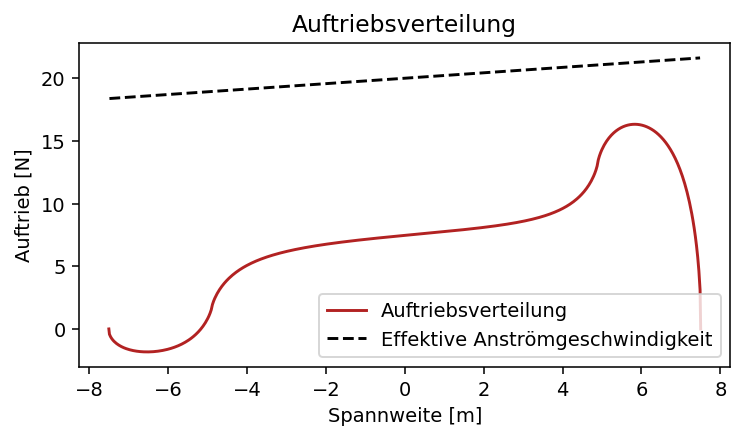

In [9]:
# Hinzufügen von Endpunkten zum plotten
A_i = np.insert(A_i, 0, 0)
A_i = np.append(A_i, 0)
y_c = np.insert(y_c, 0, -s)
y_c = np.append(y_c, s)

# Plotten der Auftriebsverteilungen
plt.figure(figsize=(6, 3))
plt.plot(y_c, A_i, '-', color="firebrick", label='Auftriebsverteilung')
plt.plot(y_c[1:-1], U_y_c, '--', color="black", label='Effektive Anströmgeschwindigkeit')
plt.xlabel('Spannweite [m]')
plt.ylabel('Auftrieb [N]')
plt.title('Auftriebsverteilung')
plt.legend()
plt.show()

## **Aufgabe 4: Ermittlung des notwendigen Klappenausschlags im stationären Kurvenflug**

a) bei einem Auftriebsbeiwert von $C_A = 0.4$ und einem Kurvenradius von $r = 80m$. 

b) bei einem Auftriebsbeiwert von $C_A = 0.3$ und einem Kurvenradius von $r = 120m$.

c) selber Auftriebsbeiwert wie in a) aber Kurvenadius wie in b)

In [10]:
# Initialisieren der benötigten Parameter
C_A_study = [0.4, 0.3, 0.4]
r_study = [80, 120, 120]
result = []

for i in range(len(C_A_study)):
    print(f"Berechne benötigten Klappenausschlag für stationären Kurvenflug bei: \n C_A={C_A_study[i]}, r={r_study[i]}m \n")
    partial_res = []

    for j in range(2):
        # Setze alpha und xi auf entsprechende Werte [0, 1]
        alpha = 1 if j==0 else 0
        xi = 0 if j==0 else 1

        # Berechnung des Nullanstellwinkels des Klappenprofils und der Drehgeschwindigkeit
        alpha_0 = - 2 / np.pi * (np.asin(np.sqrt(lamda)) + np.sqrt(lamda * (1 - lamda))) * xi
        psi = U_inf / r_study[i]

        # Berechnen der Hufeisenwirbel-Koordinaten und Koeffizientenmatrix
        y_a, y_b, y_c, x_a, x_b, x_c, y_aoo, y_boo, x_aoo, x_boo = compute_coords(s, N, delta_b, l_i, l_a)
        a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c)
        a = a_AB + a_Aoo - a_Boo    

        # Berechnen der Kräfte und Beiwerte
        C_A, C_L, _, _ = compute_forces_coeffs(np.full((a.shape[0]), alpha, dtype=float), a, s)
        partial_res.append(round(C_A, 3))
        partial_res.append(round(C_L, 3))
    
    # Ermittlung der resultierenden Kombination von Klappen- und Anstellwinkel
    xi_required = C_A_study[i] / (partial_res[2] - partial_res[0] * partial_res[3] / partial_res[1])
    alpha_required = - partial_res[3] / partial_res[1] * xi_required

    partial_res.append(round(xi_required, 2))
    partial_res.append(round(xi_required * 180 / np.pi, 2))
    partial_res.append(round(alpha_required, 2))
    partial_res.append(round(alpha_required * 180 / np.pi, 2))

    result.append(partial_res)

Berechne benötigten Klappenausschlag für stationären Kurvenflug bei: 
 C_A=0.4, r=80m 

Berechne benötigten Klappenausschlag für stationären Kurvenflug bei: 
 C_A=0.3, r=120m 

Berechne benötigten Klappenausschlag für stationären Kurvenflug bei: 
 C_A=0.4, r=120m 



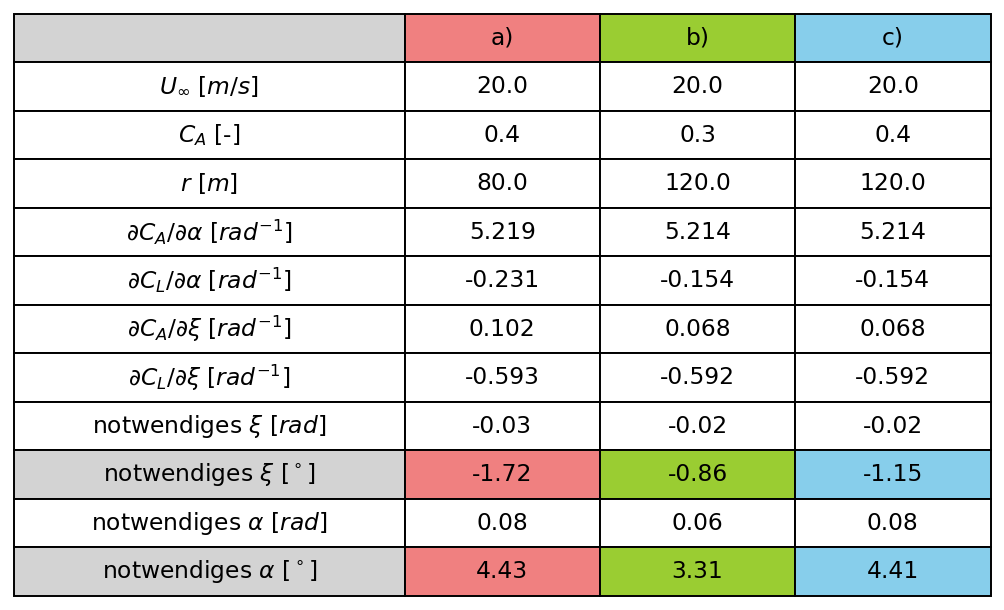

In [11]:
# Ergebnisse plotten
fig= plt.figure(figsize=(9, 5))
colColours = ["lightgray", "lightcoral", "yellowgreen", "skyblue"]

# Erstelle ein DataFrame
data = {
    "": [r"$U_\infty$ [$m/s$]", r"$C_A$ [-]", r"$r$ [$m$]", r"$\partial C_A / \partial \alpha$ [$rad^{-1}$]", r"$\partial C_L / \partial \alpha$ [$rad^{-1}$]", r"$\partial C_A / \partial \xi$ [$rad^{-1}$]", r"$\partial C_L / \partial \xi$ [$rad^{-1}$]", r"notwendiges $\xi$ [$rad$]", r"notwendiges $\xi$ [$^\circ$]", r"notwendiges $\alpha$ [$rad$]", r"notwendiges $\alpha$ [$^\circ$]"],
    "a)": [20, C_A_study[0], r_study[0]] + result[0],
    "b)": [20, C_A_study[1], r_study[1]] + result[1],
    "c)": [20, C_A_study[2], r_study[2]] + result[2]
}
df = pd.DataFrame(data)

# Erstelle die Tabelle
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=df.values, colLabels=df.columns, colColours=colColours, colWidths= [0.4, 0.2, 0.2, 0.2], cellLoc='center', loc='center')

# Zell-Eigenschaften anpassen
for key, cell in table.get_celld().items():
    cell.set_height(0.09)
    cell.set_fontsize(12)

for i in range(4):
    table[(9, i)].set_facecolor(colColours[i])
    table[(11, i)].set_facecolor(colColours[i])